In [75]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorflow.keras import layers

In [49]:
img_path = "./road/training/image_2/"
mask_path = "./road/training/gt_image_2/"

In [50]:
train_set_size = int(len(os.listdir(img_path)) * 0.8)
print(f"Number of Training Examples: {train_set_size}")

validation_set_size = int(len(os.listdir(img_path)) * 0.1)
print(f"Number of Validation Examples: {validation_set_size}")

test_set_size = int(len(os.listdir(img_path)) - train_set_size - validation_set_size)
print(f"Number of Testing Examples: {test_set_size}")

Number of Training Examples: 231
Number of Validation Examples: 28
Number of Testing Examples: 30


In [51]:
def loadImages(path,mask=False):
    result = [] 
    images = os.listdir(path)
    if mask==True:
        images = [entry for entry in images if "road" in entry]

    images=sorted(images)
    
    print(images)
    for image in images:
        im = Image.open(os.path.join(path, image))
        resized_im = im.resize((128, 128))
        res = np.asarray(resized_im)
        result.append(res)
    return np.array(result)

In [52]:
data=loadImages(img_path,mask=False)

['um_000000.png', 'um_000001.png', 'um_000002.png', 'um_000003.png', 'um_000004.png', 'um_000005.png', 'um_000006.png', 'um_000007.png', 'um_000008.png', 'um_000009.png', 'um_000010.png', 'um_000011.png', 'um_000012.png', 'um_000013.png', 'um_000014.png', 'um_000015.png', 'um_000016.png', 'um_000017.png', 'um_000018.png', 'um_000019.png', 'um_000020.png', 'um_000021.png', 'um_000022.png', 'um_000023.png', 'um_000024.png', 'um_000025.png', 'um_000026.png', 'um_000027.png', 'um_000028.png', 'um_000029.png', 'um_000030.png', 'um_000031.png', 'um_000032.png', 'um_000033.png', 'um_000034.png', 'um_000035.png', 'um_000036.png', 'um_000037.png', 'um_000038.png', 'um_000039.png', 'um_000040.png', 'um_000041.png', 'um_000042.png', 'um_000043.png', 'um_000044.png', 'um_000045.png', 'um_000046.png', 'um_000047.png', 'um_000048.png', 'um_000049.png', 'um_000050.png', 'um_000051.png', 'um_000052.png', 'um_000053.png', 'um_000054.png', 'um_000055.png', 'um_000056.png', 'um_000057.png', 'um_000058.pn

In [53]:
true_mask=loadImages(mask_path,mask=True)

['um_road_000000.png', 'um_road_000001.png', 'um_road_000002.png', 'um_road_000003.png', 'um_road_000004.png', 'um_road_000005.png', 'um_road_000006.png', 'um_road_000007.png', 'um_road_000008.png', 'um_road_000009.png', 'um_road_000010.png', 'um_road_000011.png', 'um_road_000012.png', 'um_road_000013.png', 'um_road_000014.png', 'um_road_000015.png', 'um_road_000016.png', 'um_road_000017.png', 'um_road_000018.png', 'um_road_000019.png', 'um_road_000020.png', 'um_road_000021.png', 'um_road_000022.png', 'um_road_000023.png', 'um_road_000024.png', 'um_road_000025.png', 'um_road_000026.png', 'um_road_000027.png', 'um_road_000028.png', 'um_road_000029.png', 'um_road_000030.png', 'um_road_000031.png', 'um_road_000032.png', 'um_road_000033.png', 'um_road_000034.png', 'um_road_000035.png', 'um_road_000036.png', 'um_road_000037.png', 'um_road_000038.png', 'um_road_000039.png', 'um_road_000040.png', 'um_road_000041.png', 'um_road_000042.png', 'um_road_000043.png', 'um_road_000044.png', 'um_road_

In [54]:
def convert_to_binary_mask(true_mask):
    noMasks=len(true_mask)
    for i in range(noMasks):
        #convert all masks to just binary masks (road and no road)
        road_label =np.array([255, 0, 255])
        cond=np.all(true_mask[i] == road_label, axis = 2)
        true_mask[i]=true_mask[i] * cond[..., np.newaxis]

In [55]:
convert_to_binary_mask(true_mask)

In [56]:
true_mask=np.dot(true_mask[..., :3], [0.2989, 0.5870, 0.1140])
true_mask=np.expand_dims(true_mask, axis=-1)

In [57]:
true_mask[true_mask != 0.0]=1.0

In [58]:
data  = data / 255.0

In [59]:
import albumentations as A
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

import cv2

augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    A.RGBShift(r_shift_limit=1, g_shift_limit=1, b_shift_limit=1, p=0.5),

])

In [60]:
data.shape

(289, 128, 128, 3)

In [61]:
true_mask.shape

(289, 128, 128, 1)

In [62]:
data = data.astype(np.float32)
true_mask = true_mask.astype(np.float32)

In [63]:
test_aug=augmentation_pipeline(image=data[5], mask=true_mask[5])
test_example=test_aug["image"]
test_mask=test_aug["mask"]

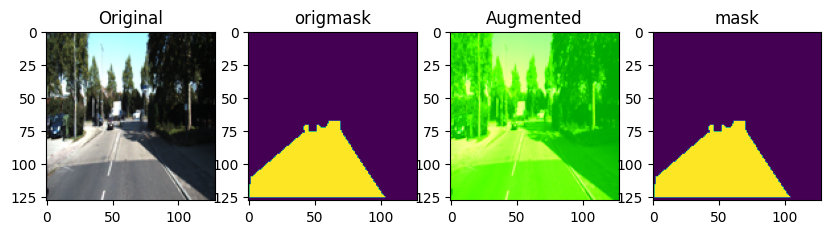

In [64]:
fig, ax = plt.subplots(1, 4, figsize=(10, 5))
ax[0].imshow(data[5])
ax[0].set_title("Original")

ax[1].imshow(true_mask[5])
ax[1].set_title("origmask")


ax[2].imshow(test_example)
ax[2].set_title("Augmented")

ax[3].imshow(test_mask)
ax[3].set_title("mask")

plt.show()

In [65]:
NewIMGS=10
for i in range(len(data)):
    for j in range(NewIMGS):
        image = data[i]
        mask = true_mask[i]
        # Apply the augmentation pipeline
        augmented = augmentation_pipeline(image=image, mask=mask)

        image_augmented = augmented["image"]
        mask_augmented = augmented["mask"]
        data = np.vstack((data, image_augmented[np.newaxis,...]))
        true_mask = np.vstack((true_mask, mask_augmented[np.newaxis,...]))

In [66]:
data.shape

(3179, 128, 128, 3)

In [67]:
true_mask.shape

(3179, 128, 128, 1)

In [68]:
img_size = (128, 128)
num_imgs = len(data)

In [69]:
train_set_size = int(len(data) * 0.8)
print(f"Number of Training Examples: {train_set_size}")

validation_set_size = int(len(data) * 0.1)
print(f"Number of Validation Examples: {validation_set_size}")

test_set_size = len(data) - train_set_size - validation_set_size
print(f"Number of Testing Examples: {test_set_size}")

Number of Training Examples: 2543
Number of Validation Examples: 317
Number of Testing Examples: 319


In [70]:
X_test=data[:test_set_size]
y_test=true_mask[:test_set_size]
print(f'test set size {X_test.shape}')


#rest of the data will be agumented and shuffled for training
data=data[test_set_size:]
true_mask=true_mask[test_set_size:]

# Shuffle the indices
shuffled_indices = np.random.permutation(len(data))

# Use the shuffled indices to shuffle both arrays
shuffled_data = data[shuffled_indices]
shuffled_masks = true_mask[shuffled_indices]

test set size (319, 128, 128, 3)


In [71]:
#train_test_validation split
X_train=shuffled_data[:train_set_size]
y_train=shuffled_masks[:train_set_size]
print(f'training set size {X_train.shape}')

X_val=shuffled_data[train_set_size:train_set_size+validation_set_size]
y_val=shuffled_masks[train_set_size:train_set_size+validation_set_size]
print(f'val set size {X_val.shape}')

training set size (2543, 128, 128, 3)
val set size (317, 128, 128, 3)


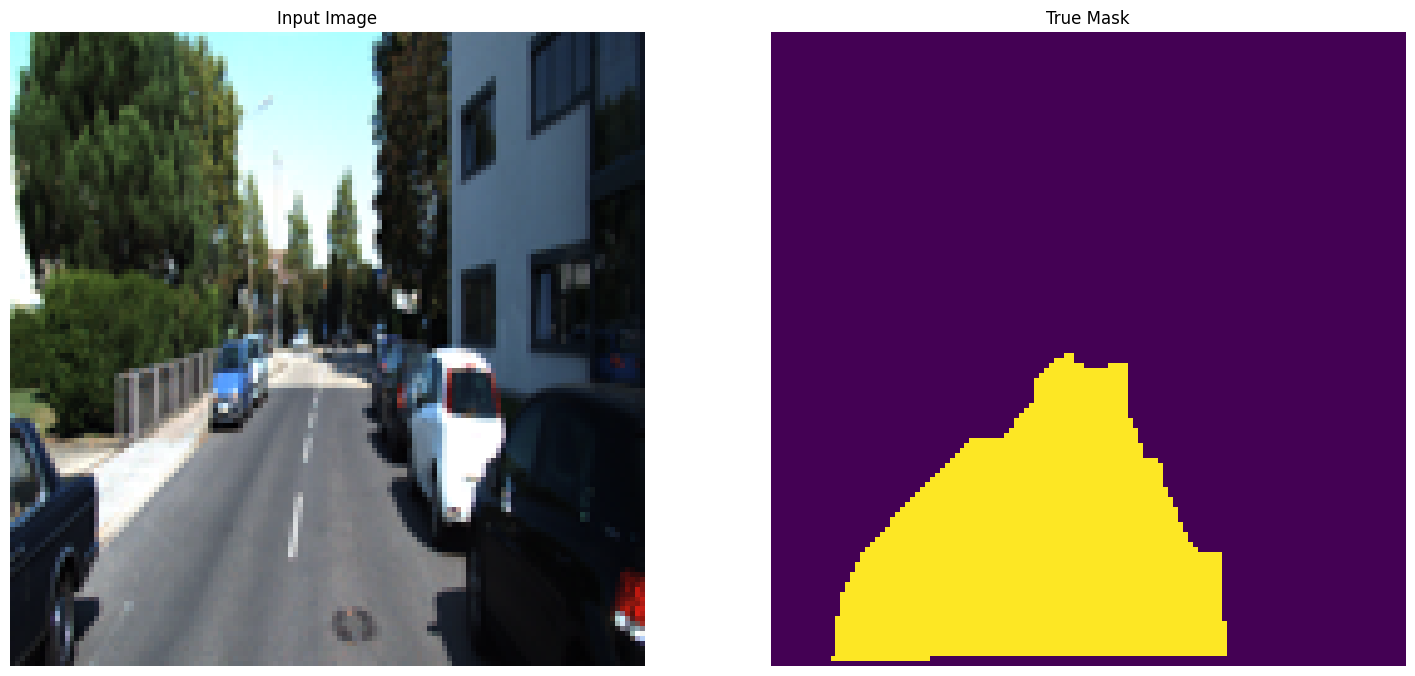

In [72]:
def display_sample(display_list):
    plt.figure(figsize = (18, 18))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    
    plt.show()
    
display_sample([data[10], true_mask[10]])

In [76]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 256)       295168

In [78]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("./models/oxford_segmentation.keras",
                                    save_best_only=True)
]

history = model.fit(X_train, y_train,
                    epochs=50,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(X_val, y_val))

Epoch 1/50
40/40 [==============================] - 380s 9s/step - loss: 0.5892 - val_loss: 0.4574
Epoch 2/50
40/40 [==============================] - 323s 8s/step - loss: 0.4482 - val_loss: 0.4811
Epoch 3/50
40/40 [==============================] - 310s 8s/step - loss: 0.3690 - val_loss: 0.3142
Epoch 4/50
40/40 [==============================] - 312s 8s/step - loss: 0.3207 - val_loss: 0.2847
Epoch 5/50
40/40 [==============================] - 320s 8s/step - loss: 0.2877 - val_loss: 0.3069
Epoch 6/50
40/40 [==============================] - 318s 8s/step - loss: 0.2862 - val_loss: 0.2645
Epoch 7/50
40/40 [==============================] - 315s 8s/step - loss: 0.2735 - val_loss: 0.2550
Epoch 8/50
40/40 [==============================] - 356s 9s/step - loss: 0.2581 - val_loss: 0.2517
Epoch 9/50
40/40 [==============================] - 320s 8s/step - loss: 0.2584 - val_loss: 0.2505
Epoch 10/50
40/40 [==============================] - 301s 8s/step - loss: 0.2534 - val_loss: 0.2463
Epoch 11/

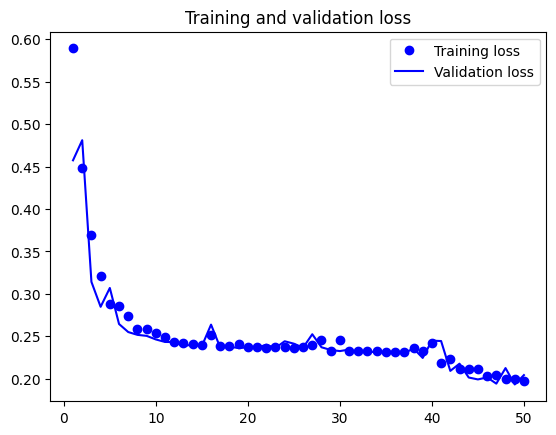

In [79]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

In [81]:
model = keras.models.load_model("./models/oxford_segmentation.keras")

In [92]:
# choosing a random test image
i = 1
test_image = X_test[i]
ground_truth_mask = (y_test[i])

In [93]:
mask = model.predict(np.expand_dims(test_image, 0))[0] 

1/1 [==============================] - 0s 108ms/step


In [94]:
print(ground_truth_mask.shape)
print(mask.shape)

(128, 128, 1)
(128, 128, 3)


In [95]:
# convert mask to 2d array by taking the argmax of the predictions
mask_reshaped = np.argmax(mask, axis=-1)
print(mask_reshaped.shape)
# extend the dimensions of the mask to be 3d - 
# this is actually not needed for visualization
# and done here just so that the shape is the same as the target, for esthetics only
mask_reshaped = np.expand_dims(mask_reshaped, -1)
print(mask_reshaped.shape)

(128, 128)
(128, 128, 1)


In [96]:
# print the predicted and ground truth classification label
print(np.unique(np.round(mask_reshaped)))
print(np.unique(ground_truth_mask))

[0 1]
[0. 1.]


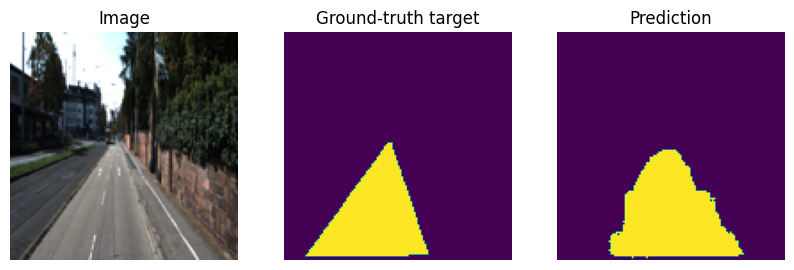

In [97]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.title("Image")
plt.axis("off")
plt.imshow(array_to_img(test_image))
plt.subplot(1, 3, 2)
plt.title("Ground-truth target")
plt.axis("off")
plt.imshow(ground_truth_mask)
plt.subplot(1, 3, 3)
plt.title("Prediction")
plt.axis("off")
plt.imshow(mask_reshaped)

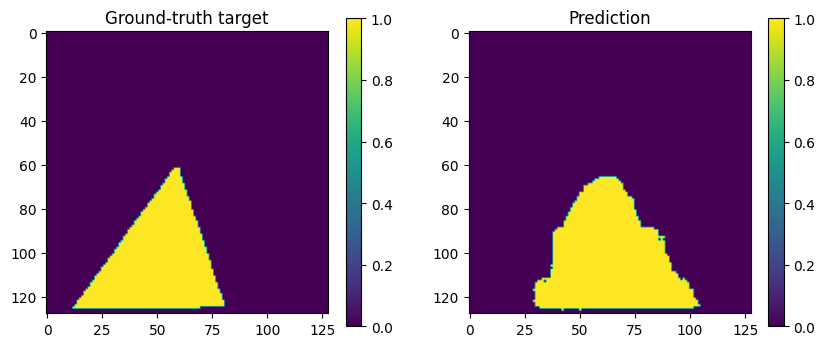

In [98]:
# show a color legend
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Ground-truth target")
plt.imshow(ground_truth_mask)
plt.colorbar()
plt.subplot(1, 2, 2)
plt.title("Prediction")
plt.imshow(mask_reshaped)
plt.colorbar()

In [99]:
from tensorflow.keras.metrics import MeanIoU

n_classes = 3
IOU_keras = MeanIoU(num_classes=n_classes)

IOU_keras.update_state(ground_truth_mask, mask_reshaped)
print("Mean IoU =", IOU_keras.result().numpy())


Mean IoU = 0.7488311
